# Multi-Agent Simulations of (Argumentative) Belief Dynamics with LMs

## General settings

In [29]:
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
import logging
from IPython.display import display, HTML
import seaborn as sns

from datetime import date
import os
import os.path
import matplotlib.pyplot as plt
import ast

from nltk import ngrams

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [20]:
from beldynlm import *

In [19]:
import importlib
import beldynlm
importlib.reload(beldynlm)
torch.cuda.empty_cache()

In [4]:
!nvidia-smi

Tue Mar 16 19:25:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 29%   28C    P8    13W / 250W |      5MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:5E:00.0 Off |                  Off |
| 34%   

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.__version__

'1.8.0+cu111'

### Model and Tokenizer

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('distilgpt2')
model.to("cuda")

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [8]:
# test model

input_tensor = (tokenizer(["I am against mandatory voting!","I am against mandatory v!","All for it, too."],padding=True,return_tensors="pt")).to('cuda')

output = model(input_tensor['input_ids'], labels = input_tensor['input_ids'] )

labels = input_tensor['input_ids']
logits = output['logits']

for t in torch.split(labels,1):
    print(t)


tensor([[   40,   716,  1028, 13677,  6709,     0]], device='cuda:0')
tensor([[   40,   716,  1028, 13677,   410,     0]], device='cuda:0')
tensor([[3237,  329,  340,   11, 1165,   13]], device='cuda:0')


### Global parameters 

In [21]:
global_parameters = {
    'topic':'compulsory_voting',
    'n_agents':16,
    'max_t':20,
    'n_initial_posts':5, # number of initial posts, simulation starts at t = n_initial_posts
    'context_size':8, # max number of posts that are included in an agents perspective
    'background_beliefs':0, # number of initial posts that will be retained as immutable background beliefs in the context, < context_size 
    'initial_neighb-peer_ratio':.5, # average ratio of neighbors that are initially considered peers
    'relevance_deprecation':.99, # how much more likely (factor) is it the agents retains a post dating from (t-k-1) than one dating from (t-k)
    'self_confidence':1, # how much more likely (factor) is it the agents retains a post from her own than from a peer 
    'n_gram_prohibition':5, # drop generated sentences as soon as n-gram of this size is repeated 
    'perspective_expansion_method':'confirmation_bias', # 'random' or 'confirmation_bias'
    'conf_bias_exponent':5,
    'peer_selection_method':'all_neighbors', # 'all_neighbors' or 'bounded_confidence'
    'fwd_batch_size': 10
}

peer_selection_parameters = [
     {
         'id':'all_neighbors'
     },
     {
         'id':'bounded_confidence',
         'epsilon':0.01
     }
#    {
#        'id':'closed_rooms',
#        'by_roomsize': False, # Determine number of rooms by n_agents/agents_per_room
#        'n_rooms':2,
#        'agents_per_room':5
#    }
]



In [22]:
decoding_parameters = {
    'do_sample':True, 
    'num_beams':5,
    'temperature': 1.1,
    'top_p': 0.9, # 0.99, 
    'top_k':0,
     #'no_repeat_ngram_size':8,
    'repetition_penalty':1.2,
    'max_length':40,
    'bad_words_ids':[[LMUtilitiesMixIn.NEWLINE_TOKENID],[LMUtilitiesMixIn.ETC_TOKENID]]
}

# Listening Agents

## Initialization

In [23]:
conversation = Conversation(global_parameters=global_parameters)
conversation.load_topic('topics/all-drugs-should-be-legalized-7100.json', tokenizer=tokenizer)

agents = []
for i in range(global_parameters['n_agents']):
    agent = ListeningLMAgent(
        model=model, 
        tokenizer=tokenizer, 
        conversation=conversation, 
        neighbors=list(range(global_parameters['n_agents'])),
        peer_selection_args=next(args for args in peer_selection_parameters if args['id']==global_parameters['peer_selection_method']),
        perspective_expansion_method=global_parameters['perspective_expansion_method'],
        decoding_args=decoding_parameters,
        agent=i
    )
    agents.append(agent)

for agent in agents:
    agent.initialize()

## Loop

In [24]:
for t in tqdm(range(global_parameters['n_initial_posts'],global_parameters['max_t'])):
    for agent in tqdm(agents, leave=False):
        # Determine peers
        agent.update_peers(t)

        # Determine perspective
        agent.update_perspective(t)
        
        # Update opinion
        agent.update_opinion(t)

        

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [25]:
conversation.save(path='', froot='test4', overwrite=True, config=[decoding_parameters])

## Visualize

In [26]:
plot_data = pd.read_csv('test4.csv',index_col=['step','agent'], skipinitialspace=True)
for col in ['perspective', 'peers']:
    plot_data[col] = plot_data[col].apply(lambda s: ast.literal_eval(s))

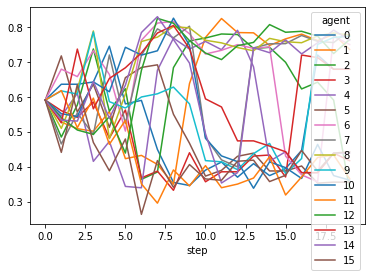

In [27]:
ax = plot_data.polarity.unstack().plot(legend=True)
#ax.legend(loc='upper left', ncol=2)

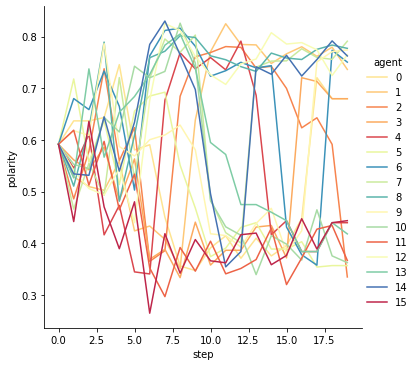

In [61]:
x0 = plot_data.loc[6]['polarity'].tolist()
palette = sns.color_palette("Spectral", as_cmap=False, n_colors=len(x0))
agents_sorted = [i for _,i in sorted(zip(x0,range(len(x0))))]
palette = {j:palette[i] for i,j in enumerate(agents_sorted)}
sns.relplot(x='step', y='polarity', hue='agent', data=plot_data.reset_index(), kind='line', palette=palette)

In [48]:
palette

[(0.208623, 0.367752, 0.552675),
 (0.280255, 0.165693, 0.476498),
 (0.395174, 0.797475, 0.367757),
 (0.845561, 0.887322, 0.099702),
 (0.159194, 0.482237, 0.558073),
 (0.13777, 0.537492, 0.554906),
 (0.274149, 0.751988, 0.436601),
 (0.237441, 0.305202, 0.541921),
 (0.128087, 0.647749, 0.523491),
 (0.281924, 0.089666, 0.412415),
 (0.121148, 0.592739, 0.544641),
 (0.263663, 0.237631, 0.518762),
 (0.688944, 0.865448, 0.182725),
 (0.182256, 0.426184, 0.55712),
 (0.535621, 0.835785, 0.281908),
 (0.180653, 0.701402, 0.488189)]

<AxesSubplot:xlabel='step'>

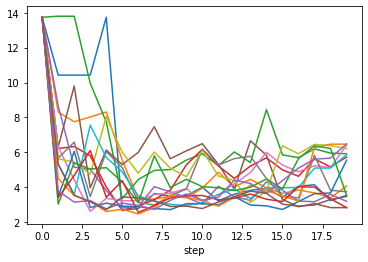

In [16]:
plot_data.salience.unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

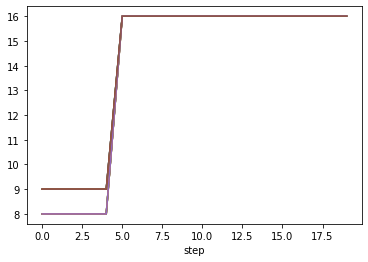

In [17]:
plot_data.peers.apply(len).unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

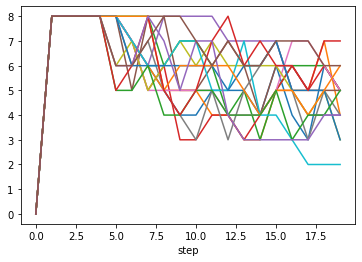

In [18]:
plot_data.perspective.apply(len).unstack().plot(legend=False)

In [25]:
plot_data.timestamps.unstack()

agent,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
step,,,,,,,,,,,,,,,,,,,,
0,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
1,"[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]"
2,"[0, 1, 1, 1, 0, 0, 0, 1]","[1, 0, 0, 1, 0, 1, 0, 0]","[0, 1, 1, 0, 0, 1, 0, 0]","[0, 1, 1, 0, 1, 0, 0, 1]","[1, 0, 0, 1, 0, 1, 1, 0]","[1, 1, 1, 1, 1, 0, 0, 0]","[1, 1, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 1, 0, 1, 0]","[0, 0, 1, 1, 0, 0, 1, 0]","[1, 0, 1, 0, 1, 1, 1, 0]","[0, 1, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 1, 0, 1, 1]","[0, 1, 1, 0, 1, 1, 0, 0]","[1, 0, 1, 1, 0, 1, 0, 1]","[1, 1, 0, 1, 0, 1, 0, 0]","[1, 0, 0, 1, 1, 0, 1, 0]","[0, 1, 1, 0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0]","[1, 1, 0, 1, 1, 1, 1, 0]","[1, 1, 0, 1, 0, 1, 1, 0]"
3,"[0, 1, 2, 1, 2, 1, 1, 0]","[2, 1, 1, 1, 1, 1, 0, 0]","[0, 0, 1, 2, 2, 2, 1, 2]","[2, 2, 1, 2, 0, 2, 1, 1]","[1, 1, 2, 1, 0, 1, 0, 2]","[2, 0, 2, 0, 1, 1, 2, 2]","[1, 2, 0, 0, 1, 0, 2, 1]","[1, 1, 2, 0, 1, 2, 2, 2]","[2, 1, 1, 1, 1, 2, 2, 0]","[2, 1, 0, 0, 0, 1, 2, 2]","[1, 0, 1, 2, 0, 2, 2, 2]","[0, 2, 1, 2, 1, 0, 2, 1]","[2, 2, 0, 1, 0, 1, 2, 2]","[1, 0, 2, 2, 1, 2, 2, 0]","[1, 1, 2, 0, 0, 1, 0, 2]","[2, 2, 1, 0, 2, 2, 1, 0]","[2, 1, 0, 2, 1, 2, 0, 0]","[2, 1, 2, 0, 0, 0, 0, 2]","[1, 0, 1, 1, 2, 0, 2, 2]","[1, 1, 0, 1, 1, 2, 2, 0]"
4,"[2, 0, 3, 3, 0, 0, 2, 2]","[0, 1, 0, 1, 2, 3, 1, 2]","[2, 1, 2, 0, 1, 3, 0, 0]","[3, 3, 0, 1, 3, 2, 3, 3]","[0, 0, 2, 3, 2, 2, 2, 2]","[0, 0, 2, 1, 3, 3, 3, 1]","[1, 0, 3, 0, 2, 0, 2, 3]","[0, 1, 3, 2, 0, 0, 1, 1]","[1, 3, 0, 0, 1, 3, 2, 2]","[0, 2, 0, 1, 3, 3, 3, 2]","[0, 1, 1, 3, 1, 1, 3, 2]","[0, 1, 3, 2, 0, 1, 1, 0]","[2, 1, 2, 2, 1, 3, 3, 3]","[1, 2, 0, 1, 1, 3, 1, 2]","[3, 0, 2, 2, 1, 3, 0, 1]","[0, 2, 3, 2, 1, 2, 3, 3]","[2, 3, 0, 2, 1, 0, 1, 1]","[0, 0, 1, 3, 2, 2, 0, 0]","[2, 1, 2, 3, 2, 3, 3, 0]","[1, 1, 1, 0, 2, 1, 2, 1]"
5,"[2, 3, 5, 5, 5]","[5, 5, 5]","[3, 5, 5, 5]","[2, 5, 5, 5]","[0, 2, 5, 5, 5, 5]","[0, 1, 5, 5, 5, 5]","[3, 5, 5, 5, 5, 5]","[1, 3, 0, 5, 5]","[3, 0, 1, 3, 2, 2, 5, 5]","[5, 5]","[1, 5, 5, 5, 5]","[1, 2, 0, 5, 5, 5]","[2, 5, 5, 5, 5, 5]","[1, 5, 5, 5, 5]","[5, 5, 5]","[5, 5, 5]","[1, 5]","[1, 2, 0, 5, 5, 5]","[2, 2, 2, 3, 3, 5]","[1, 2, 5, 5]"
6,"[3, 5, 6, 6]","[5, 6, 6, 6, 6]","[6, 6, 6, 6, 6, 6, 6, 6]","[5, 5, 6, 6]","[0, 2, 5, 5, 5, 6]","[5, 5, 6, 6, 6]","[5, 6]","[3, 6, 6, 6]","[3, 6, 6, 6, 6, 6, 6]","[6, 6, 6, 6, 6, 6, 6]","[6, 6, 6, 6, 6, 6, 6, 6]","[1, 5, 6, 6, 6]","[2, 5, 6, 6, 6, 6, 6, 6]","[5, 6, 6, 6, 6, 6]","[5, 5, 6, 6]","[5, 6, 6, 6, 6]","[5, 6, 6]","[5, 5]","[2, 2, 2, 3, 3, 6]","[6, 6, 6, 6, 6, 6, 6, 6]"
7,"[6, 7, 7, 7, 7, 7, 7]","[6, 6, 7, 7]","[6, 6]","[5, 6]","[0, 5, 7]","[5, 6, 6]","[5, 6, 7]","[3, 6, 7]","[6, 6, 6, 7, 7]","[6, 7, 7, 7, 7, 7, 7]","[6, 6, 7, 7, 7]","[5, 6, 6, 7]","[2, 6, 7, 7, 7]","[5, 6]","[7, 7, 7, 7, 7, 7, 7, 7]","[5, 6]","[5, 6, 7, 7, 7]","[5, 5]","[2, 7, 7, 7, 7]","[6, 7, 7, 7, 7, 7, 7]"
8,"[7, 8, 8]","[7, 8]","[6, 8]","[5, 6, 8]","[0, 7]","[5, 6, 8]","[5, 6]","[8, 8, 8, 8, 8, 8, 8, 8]","[8, 8, 8, 8, 8, 8]","[7, 7, 8, 8, 8]","[7, 8, 8]","[5, 6, 6, 7]","[6, 7, 7]","[8, 8, 8, 8, 8, 8, 8, 8]","[7, 8, 8]","[6, 8, 8, 8, 8, 8, 8]","[5, 6, 7, 7]","[5, 5]","[7, 7, 8]","[6, 7, 7, 7, 7, 7, 8]"


In [29]:
plot_data.perspective.unstack()[[1,2,3,4,5,12]]

agent,1,2,3,4,5,12
step,,,,,,
0,[],[],[],[],[],[]
1,"[(0, 14), (0, 5), (0, 13), (0, 15), (0, 19), (...","[(0, 10), (0, 13), (0, 14), (0, 7), (0, 0), (0...","[(0, 8), (0, 6), (0, 0), (0, 14), (0, 3), (0, ...","[(0, 1), (0, 16), (0, 17), (0, 7), (0, 8), (0,...","[(0, 18), (0, 5), (0, 13), (0, 14), (0, 7), (0...","[(0, 19), (0, 5), (0, 16), (0, 11), (0, 6), (0..."
2,"[(1, 15), (0, 11), (0, 5), (1, 13), (0, 12), (...","[(0, 11), (1, 18), (1, 8), (0, 13), (0, 8), (1...","[(0, 7), (1, 5), (1, 9), (0, 5), (1, 11), (0, ...","[(1, 5), (0, 16), (0, 9), (1, 4), (0, 19), (1,...","[(1, 18), (1, 14), (1, 16), (1, 10), (1, 12), ...","[(0, 16), (1, 3), (1, 12), (0, 15), (1, 16), (..."
3,"[(2, 14), (1, 14), (1, 13), (1, 18), (1, 12), ...","[(0, 0), (0, 18), (1, 13), (2, 13), (2, 6), (2...","[(2, 11), (2, 5), (1, 14), (2, 16), (0, 0), (2...","[(1, 8), (1, 19), (2, 7), (1, 5), (0, 7), (1, ...","[(2, 5), (0, 10), (2, 16), (0, 14), (1, 13), (...","[(2, 19), (2, 5), (0, 15), (1, 6), (0, 12), (1..."
4,"[(0, 15), (1, 12), (0, 13), (1, 13), (2, 5), (...","[(2, 11), (1, 13), (2, 7), (0, 11), (1, 7), (3...","[(3, 14), (3, 2), (0, 0), (1, 0), (3, 6), (2, ...","[(0, 1), (0, 19), (2, 17), (3, 5), (2, 14), (2...","[(0, 13), (0, 14), (2, 7), (1, 14), (3, 18), (...","[(2, 16), (1, 11), (2, 17), (2, 6), (1, 6), (3..."
5,"[(4, 1), (3, 4), (1, 9)]","[(3, 13), (4, 2), (3, 4), (1, 14)]","[(2, 0), (4, 3), (3, 1), (0, 14)]","[(0, 19), (2, 16), (4, 4), (2, 18), (1, 9), (3...","[(4, 5), (1, 6), (1, 9), (0, 7), (1, 14), (0, ...","[(2, 6), (4, 12), (3, 1), (0, 14), (1, 7), (1,..."
6,"[(4, 1), (4, 8), (4, 12), (4, 18), (4, 15)]","[(2, 0), (0, 19), (3, 15), (1, 9), (2, 18), (4...","[(4, 3), (0, 14), (1, 14), (4, 12)]","[(0, 19), (2, 16), (4, 4), (1, 9), (2, 18), (1...","[(0, 14), (4, 18), (4, 13), (4, 15), (1, 14)]","[(1, 9), (4, 8), (0, 9), (4, 13), (1, 14), (0,..."
7,"[(4, 18), (4, 15), (4, 16), (0, 14)]","[(3, 15), (4, 19)]","[(4, 12), (0, 14)]","[(0, 19), (4, 4), (1, 14)]","[(0, 14), (4, 15), (1, 14)]","[(1, 9), (1, 14), (0, 14), (4, 16), (3, 1)]"
8,"[(0, 14), (1, 14)]","[(4, 19), (1, 14)]","[(4, 12), (0, 14), (4, 13)]","[(0, 19), (1, 14)]","[(1, 14), (0, 14), (3, 1)]","[(1, 14), (0, 14), (4, 16)]"


In [18]:
display_agents = [2,3,4,6,5]
#display_agents = [2,4,6,8,0]
def get_persp(i):
    ser = plot_data.xs(i, level=1, drop_level=True)['perspective'].apply(lambda p: p)
    ser = ser.rename('agent '+str(i))
    return ser    
def get_posts(i): 
    ser = plot_data.xs(i, level=1, drop_level=True)['post'].apply(lambda p: p['text'])
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_persp(i) for i in display_agents], axis=1).to_html()
))

,agent 2,agent 3,agent 4,agent 6,agent 5
step,,,,,
0,[],[],[],[],[]
1,"[(0, 7), (0, 5), (0, 0), (0, 10), (0, 12), (0, 13), (0, 4), (0, 2)]","[(0, 14), (0, 8), (0, 11), (0, 0), (0, 1), (0, 3), (0, 12), (0, 6)]","[(0, 2), (0, 0), (0, 14), (0, 9), (0, 11), (0, 10), (0, 4), (0, 5)]","[(0, 9), (0, 13), (0, 6), (0, 7), (0, 5), (0, 8), (0, 4), (0, 2)]","[(0, 11), (0, 8), (0, 12), (0, 5), (0, 6), (0, 3), (0, 13), (0, 1)]"
2,"[(1, 12), (1, 7), (1, 5), (1, 9), (0, 2), (0, 10), (1, 0), (1, 10)]","[(0, 3), (1, 14), (1, 12), (0, 0), (1, 7), (0, 12), (1, 3), (0, 11)]","[(0, 10), (0, 11), (1, 2), (1, 11), (1, 10), (0, 2), (1, 4), (0, 5)]","[(0, 8), (1, 5), (0, 7), (0, 2), (0, 9), (1, 2), (0, 6), (1, 7)]","[(0, 5), (0, 6), (0, 11), (1, 5), (1, 13), (1, 6), (1, 12), (1, 1)]"
3,"[(1, 0), (0, 12), (1, 12), (1, 2), (2, 4), (1, 5), (0, 13), (0, 10)]","[(0, 6), (2, 1), (1, 3), (0, 1), (0, 0), (0, 11), (2, 12), (1, 14)]","[(1, 11), (2, 9), (2, 10), (0, 14), (1, 10), (2, 11), (2, 2), (0, 5)]","[(0, 8), (1, 8), (0, 9), (2, 6), (1, 6), (0, 2), (2, 2), (0, 6)]","[(0, 13), (1, 9), (0, 9), (1, 8), (0, 6), (2, 8), (2, 11), (0, 8)]"
4,"[(0, 2), (1, 5), (3, 5), (2, 10), (0, 10), (1, 4), (3, 4), (0, 5)]","[(1, 6), (1, 7), (2, 1), (2, 12), (0, 12), (1, 3), (3, 8), (3, 11)]","[(3, 5), (3, 4), (1, 0), (3, 11), (0, 11), (3, 10), (0, 14), (1, 14)]","[(1, 2), (3, 5), (0, 4), (2, 13), (1, 8), (3, 13), (1, 4), (0, 13)]","[(2, 8), (1, 3), (2, 11), (3, 9), (0, 13), (1, 9), (2, 6), (0, 1)]"
5,"[(4, 2), (3, 4)]","[(4, 3), (3, 9), (3, 10)]","[(4, 4), (3, 4)]","[(4, 6), (3, 9), (0, 14), (0, 11), (3, 4)]","[(4, 5), (0, 7), (3, 4), (1, 6)]"
6,"[(4, 0), (2, 9)]","[(2, 9), (4, 0)]","[(2, 9), (4, 0)]","[(4, 0), (2, 9)]","[(2, 9), (4, 0)]"
7,"[(2, 9), (4, 0), (3, 4)]","[(2, 9), (4, 0), (3, 4)]","[(2, 9), (4, 0), (3, 4)]","[(2, 9), (4, 0), (3, 4)]","[(2, 9), (4, 0), (3, 4)]"
8,"[(2, 9), (4, 0), (3, 4)]","[(2, 9), (4, 0), (3, 4)]","[(2, 9), (4, 0), (3, 4)]","[(2, 9), (4, 0), (3, 4)]","[(2, 9), (4, 0), (3, 4)]"


# Generating Agents

## Initialization

In [96]:
conversation = Conversation(global_parameters=global_parameters)
conversation.load_topic('topics/all-drugs-should-be-legalized-7100.json', tokenizer=tokenizer)

#conversation.load_topic('topics/compulsory_voting_polarized.json', tokenizer=tokenizer)

agents = []
for i in range(global_parameters['n_agents']):
    agent = GeneratingLMAgent(
        model=model, 
        tokenizer=tokenizer, 
        conversation=conversation, 
        neighbors=list(range(global_parameters['n_agents'])),
        peer_selection_args=next(args for args in peer_selection_parameters if args['id']==global_parameters['peer_selection_method']),
        perspective_expansion_method=global_parameters['perspective_expansion_method'],
        decoding_args=decoding_parameters,
        agent=i
    )
    agents.append(agent)

for agent in agents:
    agent.initialize()

## Loop

In [97]:
for t in tqdm(range(global_parameters['n_initial_posts'],global_parameters['max_t'])):
    for agent in agents:
        # Determine peers
        agent.update_peers(t)

        # Determine perspective
        agent.update_perspective(t)

        # Generate posts
        agent.make_contribution(t)
        
        # Update opinion
        agent.update_opinion(t)

        

  0%|          | 0/25 [00:00<?, ?it/s]

In [37]:
conversation.save(path='', froot='test3', overwrite=True, config=[decoding_parameters])

<AxesSubplot:xlabel='step'>

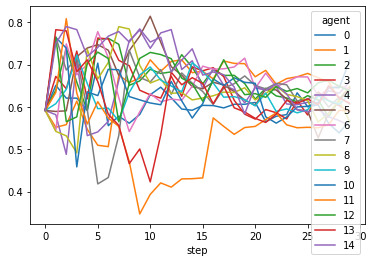

In [98]:
conversation.data.polarity.unstack().plot(legend=True)

<AxesSubplot:xlabel='step'>

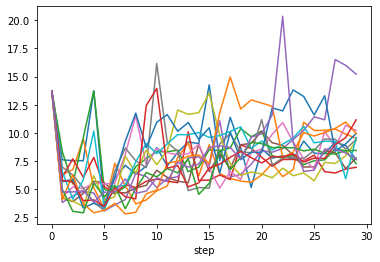

In [99]:
conversation.data.salience.unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

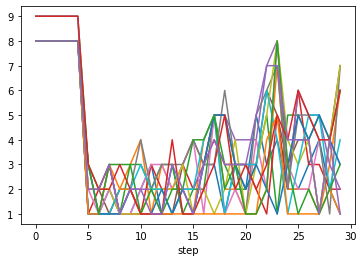

In [100]:
conversation.data.peers.apply(len).unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

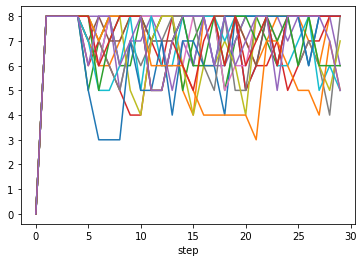

In [101]:
conversation.data.perspective.apply(len).unstack().plot(legend=False)

In [42]:
agents[0].peer_selection_args

{'id': 'bounded_confidence', 'epsilon': 0.01}

In [102]:
conversation.data.peers.unstack()

agent,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
step,,,,,,,,,,,,,,,
0,"[14, 3, 12, 10, 7, 4, 11, 0]","[2, 3, 10, 0, 14, 9, 1, 12]","[12, 14, 11, 4, 9, 0, 3, 6, 2]","[0, 5, 6, 8, 11, 3, 9, 13]","[5, 14, 1, 2, 3, 8, 6, 13, 4]","[13, 3, 8, 1, 11, 5, 10, 4]","[7, 12, 6, 8, 0, 2, 9, 3]","[13, 11, 5, 2, 10, 7, 4, 14]","[10, 8, 7, 13, 6, 4, 3, 9]","[7, 12, 9, 6, 10, 11, 13, 5]","[13, 8, 4, 11, 10, 9, 2, 5]","[3, 7, 6, 13, 8, 9, 11, 14]","[11, 4, 9, 3, 2, 8, 12, 0]","[7, 11, 2, 4, 0, 14, 5, 10, 13]","[14, 11, 12, 4, 13, 3, 5, 2]"
1,"[14, 3, 12, 10, 7, 4, 11, 0]","[2, 3, 10, 0, 14, 9, 1, 12]","[12, 14, 11, 4, 9, 0, 3, 6, 2]","[0, 5, 6, 8, 11, 3, 9, 13]","[5, 14, 1, 2, 3, 8, 6, 13, 4]","[13, 3, 8, 1, 11, 5, 10, 4]","[7, 12, 6, 8, 0, 2, 9, 3]","[13, 11, 5, 2, 10, 7, 4, 14]","[10, 8, 7, 13, 6, 4, 3, 9]","[7, 12, 9, 6, 10, 11, 13, 5]","[13, 8, 4, 11, 10, 9, 2, 5]","[3, 7, 6, 13, 8, 9, 11, 14]","[11, 4, 9, 3, 2, 8, 12, 0]","[7, 11, 2, 4, 0, 14, 5, 10, 13]","[14, 11, 12, 4, 13, 3, 5, 2]"
2,"[14, 3, 12, 10, 7, 4, 11, 0]","[2, 3, 10, 0, 14, 9, 1, 12]","[12, 14, 11, 4, 9, 0, 3, 6, 2]","[0, 5, 6, 8, 11, 3, 9, 13]","[5, 14, 1, 2, 3, 8, 6, 13, 4]","[13, 3, 8, 1, 11, 5, 10, 4]","[7, 12, 6, 8, 0, 2, 9, 3]","[13, 11, 5, 2, 10, 7, 4, 14]","[10, 8, 7, 13, 6, 4, 3, 9]","[7, 12, 9, 6, 10, 11, 13, 5]","[13, 8, 4, 11, 10, 9, 2, 5]","[3, 7, 6, 13, 8, 9, 11, 14]","[11, 4, 9, 3, 2, 8, 12, 0]","[7, 11, 2, 4, 0, 14, 5, 10, 13]","[14, 11, 12, 4, 13, 3, 5, 2]"
3,"[14, 3, 12, 10, 7, 4, 11, 0]","[2, 3, 10, 0, 14, 9, 1, 12]","[12, 14, 11, 4, 9, 0, 3, 6, 2]","[0, 5, 6, 8, 11, 3, 9, 13]","[5, 14, 1, 2, 3, 8, 6, 13, 4]","[13, 3, 8, 1, 11, 5, 10, 4]","[7, 12, 6, 8, 0, 2, 9, 3]","[13, 11, 5, 2, 10, 7, 4, 14]","[10, 8, 7, 13, 6, 4, 3, 9]","[7, 12, 9, 6, 10, 11, 13, 5]","[13, 8, 4, 11, 10, 9, 2, 5]","[3, 7, 6, 13, 8, 9, 11, 14]","[11, 4, 9, 3, 2, 8, 12, 0]","[7, 11, 2, 4, 0, 14, 5, 10, 13]","[14, 11, 12, 4, 13, 3, 5, 2]"
4,"[14, 3, 12, 10, 7, 4, 11, 0]","[2, 3, 10, 0, 14, 9, 1, 12]","[12, 14, 11, 4, 9, 0, 3, 6, 2]","[0, 5, 6, 8, 11, 3, 9, 13]","[5, 14, 1, 2, 3, 8, 6, 13, 4]","[13, 3, 8, 1, 11, 5, 10, 4]","[7, 12, 6, 8, 0, 2, 9, 3]","[13, 11, 5, 2, 10, 7, 4, 14]","[10, 8, 7, 13, 6, 4, 3, 9]","[7, 12, 9, 6, 10, 11, 13, 5]","[13, 8, 4, 11, 10, 9, 2, 5]","[3, 7, 6, 13, 8, 9, 11, 14]","[11, 4, 9, 3, 2, 8, 12, 0]","[7, 11, 2, 4, 0, 14, 5, 10, 13]","[14, 11, 12, 4, 13, 3, 5, 2]"
5,"[0, 2, 7]",[1],"[0, 2, 7]",[3],[4],"[5, 8]","[6, 12]","[0, 2, 7]","[5, 8]",[9],[10],[11],"[6, 12, 13]","[12, 13, 14]","[13, 14]"
6,[0],[1],"[2, 3]","[2, 3]",[4],"[5, 14]",[6],[7],"[8, 13]",[9],[10],[11],[12],"[8, 13]","[5, 14]"
7,"[0, 4]",[1],"[2, 3, 14]","[2, 3, 14]","[0, 4, 11]",[5],"[6, 12]",[7],"[8, 12]",[9],[10],"[4, 11, 13]","[6, 8, 12]","[11, 13]","[2, 3, 14]"
8,[0],"[1, 5]",[2],[3],[4],"[1, 5]",[6],[7],[8],"[9, 12]",[10],"[11, 13]","[9, 12, 13]","[11, 12, 13]",[14]


In [55]:
conversation.data.perspective.unstack().loc[8][0]


[(2, 2), (7, 0), (4, 7), (5, 0), (6, 0), (0, 8), (1, 9), (2, 8)]

In [103]:
display_agents = [2,6,5,13,9]
#display_agents = [2,4,6,8,0]
def get_posts(i): 
    ser = conversation.data.xs(i, level=1, drop_level=True)['post'].apply(lambda p: p['text'])
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

,agent 2,agent 6,agent 5,agent 13,agent 9
step,,,,,
0,"Such stress might be irrational, especially when it's related to unproblematic drug use. In that case, the psychological stress is the fault of the persons irrational beliefs. So all drugs should be legal.",A large portion of the public is irresponsible. Giving everyone the opportunity to use \(or abuse\) drugs would have negative consequences on these individuals. I think drugs should remain illegal.,"If recreational drugs were legal, social events such as parties would have more variety. Drug-friendly events would also have no cause for paranoia.I believe all drugs should be legal.",The legalisation of drugs could lead to better education on how to be safe around them. That's why all drugs should be legal.,The negative repercussions of drug use should be prosecuted on their own merit and context \(without prosecuting the drug use itself\). That's why all drugs should be legal.
1,Children of drug addicts would have a much higher chance of receiving the appropriate help if drug users did not have to hide. So legalization of drugs is a pretty good idea.,"When weed was legalized in Colorado for recreational use, the [usage rate](https://www.reuters.com/article/us-colorado-marijuana-idUSKCN0Z702N) among teens and children stayed the same. I think all drugs should be legal.",Justifying a ban because it provides people with more autonomy is an inherent contradiction. That's why legalization of drugs is a pretty good idea.,"Optimal treatment of addiction sometimes means [needing to taper off](https://www.therecoveryvillage.com/heroin-addiction/heroin-taper/) a drug, however, under prohibition quitting ""cold turkey"" is the only legal option. I think legalization of drugs is a pretty good idea.","While some might overestimate the revenue, there still will be revenue. If it is 1/2 or 1/3 of those naive estimates, it is still revenue, and it still increases the government coffers. That's why legalization of drugs is a pretty good idea."
2,"Even though illegal drugs may still exist if drugs were legalised, there would be far less of them than when illegal drugs were the only option. So all drugs should be legal.","The legalization of drugs means that they are taken, and disposed of, more safely and cautiously than in the current environment.I believe legalization of drugs is a pretty good idea.",Education on how to be safe with drugs can be seen as an incentive to use them. That's why legalization of drugs is a really bad idea.,Regulations that prohibit working under the influence of alcohol can trivially be expanded to include all drugs. I think legalization of drugs is a pretty good idea.,A large portion of the public is irresponsible. Giving everyone the opportunity to use \(or abuse\) drugs would have negative consequences on these individuals. I think drugs should remain illegal.
3,"If drugs being illegal prevented addiction, there would be no drug addicted person. Thus, there is no prevention by just keeping drugs illegal.I believe all drugs should be legal.","The first [anti-marijuana laws](http://www.drugpolicy.org/issues/brief-history-drug-war), in the Midwest and the Southwest in the 1910s and 20s, were directed at Mexican migrants and Mexican Americans. So legalization of drugs is a pretty good idea.",A high level of correlation does not indicate which of the variables is the cause and which is the effect. That's why legalization of drugs is a pretty good idea.,Evidence suggests that [addiction is not caused by drugs](https://www.youtube.com/watch?v=ao8L-0nSYzg) but by social problems.I believe all drugs should be legal.,"Since everything is legal, users can instead choose the drugs with the most benefits and the least harms. So all drugs should be legal."
4,"In [many countries](https://en.wikipedia.org/wiki/Regulation_of_nicotine_marketing), the advertisement of cigarettes and alcohol is not allowed. The same model could be adopted in the regulation of legalized drugs. 

In [418]:
from datetime import date
import os
import os.path
today = date.today().isoformat()
today
filename_root = "bd_results_"+today+"_"
result_files_today = [f for f in os.listdir('.') if f.startswith(filename_root)]
filename=filename_root+str(len(result_files_today)+1)+".csv"

conversation.data.to_csv(filename)

# DEPRECATED

## Define Dynamics

### Peer selection

In [465]:
peer_sel_param = next(p for p in peer_selection_parameters if p['id']==global_parameters['peer_selection_method'])

if peer_sel_param['id']=='closed_rooms':
    n_rooms = round(global_parameters['n_agents']/peer_sel_param['agents_per_room']) if peer_sel_param['by_roomsize'] else peer_sel_param['n_rooms']
    #assign each agent a room
    #room_assignments = random.choices(list(range(n_rooms)),k=global_parameters['n_agents']) # random
    room_assignments = [i%n_rooms for i in range(global_parameters['n_agents'])] # modulo
    #print(room_assignments)
    peers = [[j for j,r in enumerate(room_assignments) if r==room_assignments[i]] for i in range(global_parameters['n_agents'])]
    #print(peers)
    
    def peer_selection(df,t):
        return peers

### Context creation

In [466]:
def context_creation(df,t):
    c_max = global_parameters['context_size']
    delta = global_parameters['relevance_deprecation']
    context_old = df.loc[t-1]['context'] # start with context from previous step
    context_old = context_old.rename('old')
    context_new = df.loc[t]['peers'].apply(lambda peers: [[t-1,p] for p in peers])# all the new stuff the peers have been saying at t
    context_new = context_new.rename('new')
    
    def merge_and_drop(row):
        con = row.new + row.old
        if len(con)>global_parameters['context_size']:
            con_sampled = []
            for i in range(global_parameters['context_size']):
                weights = [(global_parameters['self_confidence'] if x[1]==row.agent else 1) * (delta**(t-x[0])) for x in con]
                #print(weights)
                retain = random.choices(con,k=1,weights=weights)[0]
                con.remove(retain)
                con_sampled.append(retain)
            con = con_sampled
        return con
    contexts = pd.concat([context_old,context_new,pd.Series(agents,name='agent')],axis=1).apply(merge_and_drop, axis=1)
    return contexts

### Generation of posts

## Initialization

In [17]:
topic = next(t for t in topics if t['id']==global_parameters['topic'])
topic['intro_tokens'] = tokenizer(topic['intro'])['input_ids']
topic['prompt_tokens'] = tokenizer(topic['prompt'])['input_ids']

We store all the results in hiarchically indexed dataframe.

In [57]:
Conversation(global_parameters,topic).data

post peers context tokens
step agent                          
0    0        0    []      []      0
     1        0    []      []      0
     2        0    []      []      0
     3        0    []      []      0
     4        0    []      []      0
...         ...   ...     ...    ...
49   5        0    []      []      0
     6        0    []      []      0
     7        0    []      []      0
     8        0    []      []      0
     9        0    []      []      0

[500 rows x 4 columns]

In [469]:
columns = ['post','peers','context','tokens']
steps = np.arange(global_parameters['max_t'])
agents = np.arange(global_parameters['n_agents'])
steps_agents = [
   steps,
   agents
]
index = pd.MultiIndex.from_product(steps_agents, names=["step", "agent"])
df = pd.DataFrame(np.zeros((global_parameters['max_t']*global_parameters['n_agents'], len(columns))), index=index, columns=columns)
df = df.astype(object)
df['context']=[[] for i in range(len(df))]
df['peers']=[[] for i in range(len(df))]

We initialize peer groups.

In [470]:
# initialize peers
for t in range(global_parameters['n_initial_posts']):
    df.loc[t]['peers']=peer_selection(df,t)

We initialize context.

In [471]:
for t in range(1,global_parameters['n_initial_posts']):
    df.loc[t]['context']=context_creation(df,t)

We initialize posts (from topic)

In [472]:
for t in range(global_parameters['n_initial_posts']):
    #new_series = pd.Series(
    #    random.choices(topic['initial_posts'],k=global_parameters['n_agents']),
    #    index = pd.RangeIndex(global_parameters['n_agents'], name='agent')
    #)
    # df.loc[t]['post'] = random.choices(topic['initial_posts'],k=global_parameters['n_agents']) # random
    # pro / con split in groups
    pros = [p for p in topic['initial_posts'] if p['type']=='pro']
    cons = [p for p in topic['initial_posts'] if p['type']=='con']
    df.loc[t]['post'] = df.loc[t]['peers'].apply(lambda peers: random.choice(pros) if (0 in peers) else random.choice(cons)) 
    df.loc[t]['tokens'] = df.loc[t]['post'].apply(lambda p: tokenizer(p['text'])['input_ids'])

In [473]:
df.loc[:2]

post  \
step agent                                                      
0    0      {'type': 'pro', 'text': 'Voting is compulsory ...   
     1      {'type': 'con', 'text': 'There are many reason...   
     2      {'type': 'pro', 'text': 'Since the poor and di...   
     3      {'type': 'con', 'text': 'Many people cannot ge...   
     4      {'type': 'pro', 'text': 'Low participation rat...   
     5      {'type': 'con', 'text': 'The alleged crisis of...   
     6      {'type': 'pro', 'text': 'Voting is compulsory ...   
     7      {'type': 'con', 'text': 'The alleged crisis of...   
     8      {'type': 'pro', 'text': 'Low participation rat...   
     9      {'type': 'con', 'text': 'The alleged crisis of...   
1    0      {'type': 'pro', 'text': 'Since the poor and di...   
     1      {'type': 'con', 'text': 'Many people cannot ge...   
     2      {'type': 'pro', 'text': 'Voting is compulsory ...   
     3      {'type': 'con', 'text': 'There are many reason...   
     4      {'type': 'pro', 'text': 'Since the poor and di...   
     5      {'type': 'con', 'text': 'There are many reason...   
     6      {'type': 'pro', 'text': 'Since the poor and di...   
     7      {'type': 'con', 'text': 'Many people cannot ge...   
     8      {'type': 'pro', 'text': 'Liberal democracy rel...   
     9      {'type': 'con', 'text': 'Compulsory voting wou...   
2    0                                                      0   
     1                                                      0   
     2                                                      0   
     3                                                      0   
     4                                                      0   
     5                                                      0   
     6                                                      0   
     7                                                      0   
     8                                                      0   
     9                                                      0   

                      peers                                   context  \
step agent                                                              
0    0      [0, 2, 4, 6, 8]                                        []   
     1      [1, 3, 5, 7, 9]                                        []   
     2      [0, 2, 4, 6, 8]                                        []   
     3      [1, 3, 5, 7, 9]                                        []   
     4      [0, 2, 4, 6, 8]                                        []   
     5      [1, 3, 5, 7, 9]                                        []   
     6      [0, 2, 4, 6, 8]                                        []   
     7      [1, 3, 5, 7, 9]                                        []   
     8      [0, 2, 4, 6, 8]                                        []   
     9      [1, 3, 5, 7, 9]                                        []   
1    0      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     1      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     2      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     3      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     4      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     5      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     6      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     7      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     8      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     9      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
2    0                   []                                        []   
     1                   []                                        []   
     2                   []                                        []   
     3                   []                                        []   
     4                   []                                        []   
     

In [ ]:
display_agents = [1,3,6,7,9]
#display_agents = [2,4,6,8,0]
def get_posts(i): 
    ser = df.xs(i, level=1, drop_level=True)['post'].apply(lambda p: p['text'])
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

# Loop

In [474]:
for t in tqdm(range(global_parameters['n_initial_posts'],global_parameters['max_t'])):
    # Determine peers
    df.loc[t]['peers']=peer_selection(df,t)
    # Determine contexts
    df.loc[t]['context']=context_creation(df,t)
    # Generate posts
    df_posts_tokens=posts_creation(df,t)
    df.loc[t]['post']=df_posts_tokens['post']
    df.loc[t]['tokens']=df_posts_tokens['tokens']

  0%|          | 0/48 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  2%|▏         | 1/48 [00:17<13:50, 17.68s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for o

In [216]:
display_agents = [1,3,6,7,9]
#display_agents = [2,4,6,8,0]
def get_posts(i): 
    ser = df.xs(i, level=1, drop_level=True)['post'].apply(lambda p: p['text'])
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

NameError: name 'df' is not defined

In [ ]:
display_agents = [0,1,2]
def get_posts(i): 
    ser = df.xs(i, level=1, drop_level=True)['tokens']
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

## Save

In [478]:
from datetime import date
import os
import os.path
today = date.today().isoformat()
today
filename_root = "bd_results_"+today+"_"
result_files_today = [f for f in os.listdir('.') if f.startswith(filename_root)]
filename=filename_root+str(len(result_files_today)+1)+".csv"

df.to_csv(filename)


bd_results_2021-02-26_


In [479]:
!ls

README.md		     bd_results_2021-02-26_2.csv     env_bd-lm
bd_results_2021-02-26_1.csv  belief-dynamics_with_lms.ipynb  wandb


In [480]:
pd.read_csv('bd_results_2021-02-26_1.csv',index_col=['step', 'agent']).head()

post  \
step agent                                                      
0    0      {'type': 'pro', 'text': 'Turnout in British el...   
     1      {'type': 'pro', 'text': 'Turnout in British el...   
     2      {'type': 'pro', 'text': 'Turnout in British el...   
     3      {'type': 'con', 'text': 'There are many reason...   
     4      {'type': 'con', 'text': "Some people who don't...   

                      peers context  \
step agent                            
0    0      [0, 1, 2, 5, 9]      []   
     1      [0, 1, 2, 5, 9]      []   
     2      [0, 1, 2, 5, 9]      []   
     3      [3, 4, 6, 7, 8]      []   
     4      [3, 4, 6, 7, 8]      []   

                                                       tokens  
step agent                                                     
0    0      [17278, 448, 287, 3517, 3071, 318, 17087, 4420...  
     1      [17278, 448, 287, 3517, 3071, 318, 17087, 4420...  
     2      [17278, 448, 287, 3517, 3071, 318, 17087, 4420...  
     3      [1858, 389, 867, 3840, 1521, 661, 466, 407, 30...  
     4      [4366, 661, 508, 836, 470, 3015, 2314, 651, 10...

# Evaluate

In [192]:
def conditional_loss(labels, logits, k_last_tokens):
  # Shift so that logits at index n predict token n in labels
  shift_logits = logits[..., :-1, :].contiguous() # drop last token
  shift_labels = labels[..., 1:].contiguous() # drop first token; this effectively causes the shift

  # Only keep last k_last_tokens tokens
  shift_logits = shift_logits[..., -k_last_tokens:, :].contiguous()
  shift_labels = shift_labels[..., -k_last_tokens:].contiguous() 

  # use CrossEntropy loss function
  loss_fct = torch.nn.CrossEntropyLoss()
  last_k_loss = loss_fct(
    # Flatten the tokens, i.e. reduce dimension
    shift_logits.view(-1, shift_logits.size(-1)), 
    shift_labels.view(-1)
  ) 

  return last_k_loss 

In [246]:
pro_claim = " I am for compulsory voting."
con_claim = " I am against compulsory voting."
connector = " And therefore, all in all,"

In [247]:
# unconditional entropy pro-claim
token_ids_cond = tokenizer(connector)
token_ids = tokenizer(pro_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

8.077747000305946

In [248]:
# unconditional entropy con-claim
token_ids_cond = tokenizer(connector)
token_ids = tokenizer(con_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

6.883872364989321

#### Unconditional Pro/Con-Ratio  (higher value >> favoring con claim)

In [88]:
1.9476037105562336/1.3596544975807243

1.4324254536881726

In [71]:
pros = " ".join([s['text'] for s in topic['initial_posts'] if s['type']=='pro'])
cons = " ".join([s['text'] for s in topic['initial_posts'] if s['type']=='con'])

In [76]:
# entropy pro-claim conditional on pro-reasons
token_ids_cond = tokenizer(pros + connector)
token_ids = tokenizer(pro_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.6826535361100052

In [77]:
# entropy con-claim conditional on pro-reasons
token_ids_cond = tokenizer(pros + connector)
token_ids = tokenizer(" " + con_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.1704144492766078

#### Pro/Con-Ratio conditional on PROS (higher value >> favoring con claim)

In [79]:
1.6826535361100052/1.1704144492766078

1.4376561543220818

In [81]:
# entropy pro-claim conditional on con-reasons
token_ids_cond = tokenizer(cons + connector)
token_ids = tokenizer(" " + pro_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.9033692724649254

In [82]:
# entropy con-claim conditional on con-reasons
token_ids_cond = tokenizer(cons + connector)
token_ids = tokenizer(" " + con_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.250969822522566

#### Pro/Con-Ratio conditional on CONS (higher value >> favoring con claim)

In [83]:
1.9033692724649254/1.250969822522566

1.5215149384073898